In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
device

'/GPU:0'

# Load Data

In [3]:
training_dataset_path = 'data/training_dataset.csv'
training_df = pd.read_csv(training_dataset_path)
print("Shape:", training_df.shape)

Shape: (8795, 55)


In [4]:
training_text = training_df['Title']
features = training_df.columns[1:]
training_labels = training_df[features]
num_classes = len(features)
print("Number of classes:", num_classes)

Number of classes: 54


# Transform

## Tokenize

In [5]:
# create indobert tokenizer instance
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
vocab_size = len(tokenizer.vocab.keys())
print("Number of vocabulary:", vocab_size)

Number of vocabulary: 30521


In [6]:
# tokenize the title
training_sequences = training_text.apply(lambda sequence: tokenizer.encode(sequence))
print("Real sentence:\n", training_text[4444])
print("Tokenized sentence:\n", training_sequences[4444])

Real sentence:
 tetap wewenang direktur jender anggar imbang uang direktur jender bendahara serta wewenang kepala kantor instansi vertik direktorat jender bendahara rangka laksana anggar dapat belanja negara tahun anggar
Tokenized sentence:
 [2, 830, 8517, 4726, 4796, 22931, 30359, 11907, 988, 4726, 4796, 14272, 501, 8517, 1179, 1571, 5288, 8858, 39, 9170, 4796, 14272, 3489, 18303, 22931, 30359, 173, 3866, 664, 262, 22931, 30359, 3]


## Padding

In [7]:
max_length = 100
padded_sequences = pad_sequences(training_sequences, maxlen=max_length)
print("Shape:", padded_sequences[4444].shape)

Shape: (100,)


## Class Weight

In [8]:
class_df = pd.DataFrame()
class_df['class'] = features
class_df['count'] = training_df.iloc[:, 1:].sum().values
class_df['weight'] = len(class_df) / class_df['count']
class_df.head()

,class,count,weight
0,Jenis Dan Tarif,52,1.038462
1,Penerimaan Negara Bukan Pajak,131,0.412214
2,Pajak Bumi Dan Bangunan,94,0.574468
3,Kementerian Keuangan,105,0.514286
4,Perubahan Kedua,162,0.333333


In [9]:
class_names = class_df['class'].values
class_weight = {}
for index, class_name in enumerate(class_names):
    class_weight[index] = class_df[class_df['class'] == class_names]['weight'].values[0]

# Model

## Create Model

In [ ]:
embedding_dimensions = 64
inputs = tf.keras.Input(shape=(100,), name='input')
x = tf.keras.layers.Embedding(vocab_size, embedding_dimensions, input_length=max_length)(inputs)

In [ ]:
# cnn
x_1 = tf.keras.layers.Dropout(.13)(x)
x_1 = tf.keras.layers.Conv1D(128, 3, activation='relu')(x_1)
x_1 = tf.keras.layers.MaxPool1D(2)(x_1)
x_1 = tf.keras.layers.Flatten()(x_1)
concatted_x_1 = tf.keras.layers.Concatenate()([x_1, x_1, x_1])

In [ ]:
# lstm
x_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
x_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x_2)
x_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x_2)

In [ ]:
concatted_x = tf.keras.layers.Concatenate()([concatted_x_1, x_2])
x = tf.keras.layers.Dropout(.3)(concatted_x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(x)

In [ ]:
# LSTM
embedding_dimensions = 64
inputs = tf.keras.Input(shape=(100,), name='input')
x = tf.keras.layers.Embedding(vocab_size, embedding_dimensions, input_length=max_length)(inputs)
x = tf.keras.layers.LSTM(64)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(x)

In [24]:
# SIMPLE DNN
embedding_dimensions = 64
inputs = tf.keras.Input(shape=(100,), name='input')
x = tf.keras.layers.Embedding(vocab_size, embedding_dimensions, input_length=max_length)(inputs)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(x)

In [25]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='kaidah_model')
model.summary()

Model: "kaidah_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 64)           1953344   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 54)                3510      
Total params: 1,956,854
Trainable params: 1,956,854
Non-trainable params: 0
_________________________________________________________________


In [26]:
# compile model
optimizer = tf.keras.optimizers.Adam(3e-5)
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

## Training

In [27]:
# reduce learning rate and save model
saved_model_path = 'dnn_kaidah_model.h5'
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(), 
             tf.keras.callbacks.ModelCheckpoint(saved_model_path, save_best_only=True)]

In [28]:
num_epoch = 100
batch_size = 128
history = model.fit(padded_sequences, training_labels, batch_size=batch_size, class_weight=class_weight,
                    epochs=num_epoch, validation_split=0.3, callbacks=callbacks)

Epoch 1/100
49/49 [==============================] - 2s 27ms/step - loss: 0.7116 - accuracy: 0.0011 - auc: 0.6681 - val_loss: 0.6830 - val_accuracy: 0.0243 - val_auc: 0.7200
Epoch 2/100
49/49 [==============================] - 1s 23ms/step - loss: 0.7083 - accuracy: 9.7466e-04 - auc: 0.7226 - val_loss: 0.6798 - val_accuracy: 0.0243 - val_auc: 0.7519
Epoch 3/100
49/49 [==============================] - 1s 23ms/step - loss: 0.7049 - accuracy: 9.7466e-04 - auc: 0.7593 - val_loss: 0.6766 - val_accuracy: 0.0243 - val_auc: 0.7623
Epoch 4/100
49/49 [==============================] - 1s 23ms/step - loss: 0.7014 - accuracy: 9.7466e-04 - auc: 0.7801 - val_loss: 0.6732 - val_accuracy: 0.0243 - val_auc: 0.7769
Epoch 5/100
49/49 [==============================] - 1s 23ms/step - loss: 0.6978 - accuracy: 0.0045 - auc: 0.7987 - val_loss: 0.6697 - val_accuracy: 0.0299 - val_auc: 0.7882
Epoch 6/100
49/49 [==============================] - 1s 23ms/step - loss: 0.6941 - accuracy: 0.0621 - auc: 0.8121 - va

Epoch 48/100
49/49 [==============================] - 1s 23ms/step - loss: 0.4114 - accuracy: 0.6153 - auc: 0.8288 - val_loss: 0.3997 - val_accuracy: 0.2793 - val_auc: 0.7987
Epoch 49/100
49/49 [==============================] - 1s 23ms/step - loss: 0.4038 - accuracy: 0.6153 - auc: 0.8287 - val_loss: 0.3926 - val_accuracy: 0.2793 - val_auc: 0.7988
Epoch 50/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3961 - accuracy: 0.6153 - auc: 0.8288 - val_loss: 0.3856 - val_accuracy: 0.2793 - val_auc: 0.7989
Epoch 51/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3886 - accuracy: 0.6153 - auc: 0.8287 - val_loss: 0.3786 - val_accuracy: 0.2793 - val_auc: 0.7964
Epoch 52/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3811 - accuracy: 0.6153 - auc: 0.8289 - val_loss: 0.3718 - val_accuracy: 0.2793 - val_auc: 0.7967
Epoch 53/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3736 - accuracy: 0.6153 - auc: 0.8286 - val_loss

Epoch 95/100
49/49 [==============================] - 1s 23ms/step - loss: 0.1546 - accuracy: 0.6153 - auc: 0.8307 - val_loss: 0.1711 - val_accuracy: 0.2793 - val_auc: 0.7904
Epoch 96/100
49/49 [==============================] - 1s 23ms/step - loss: 0.1515 - accuracy: 0.6153 - auc: 0.8303 - val_loss: 0.1685 - val_accuracy: 0.2793 - val_auc: 0.7968
Epoch 97/100
49/49 [==============================] - 1s 22ms/step - loss: 0.1485 - accuracy: 0.6153 - auc: 0.8310 - val_loss: 0.1660 - val_accuracy: 0.2793 - val_auc: 0.7910
Epoch 98/100
49/49 [==============================] - 1s 23ms/step - loss: 0.1456 - accuracy: 0.6153 - auc: 0.8309 - val_loss: 0.1636 - val_accuracy: 0.2793 - val_auc: 0.7882
Epoch 99/100
49/49 [==============================] - 1s 23ms/step - loss: 0.1427 - accuracy: 0.6153 - auc: 0.8311 - val_loss: 0.1613 - val_accuracy: 0.2793 - val_auc: 0.7921
Epoch 100/100
49/49 [==============================] - 1s 22ms/step - loss: 0.1400 - accuracy: 0.6153 - auc: 0.8307 - val_los

## Plot Metric

In [29]:
directory = 'metric/'
if not os.path.exists(directory):
    os.mkdir(directory)

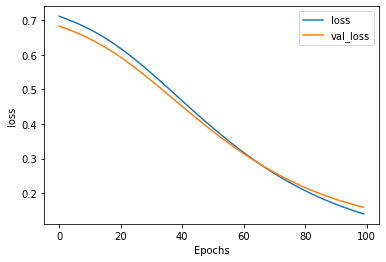

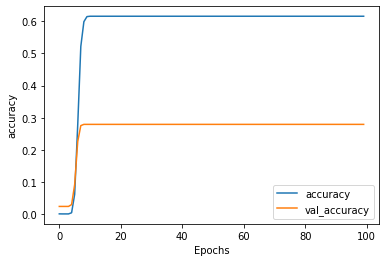

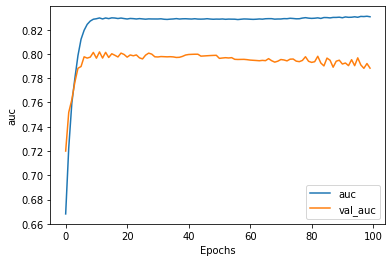

In [31]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(directory+'dnn_'+string+'.png')
    plt.show()

for metric in model.metrics_names:
    plot_graphs(history, metric)

# Save Class

In [ ]:
# add id as new column
class_df.insert(0, 'id', class_df.index+1)
class_df.pop('count')
class_df.pop('weight')
class_df.columns

In [ ]:
# save to directory
directory = 'data/'
if not os.path.exists(directory):
    os.mkdir(directory)

saved_data_path = os.path.join(directory, 'label.csv')
class_df.to_csv(saved_data_path, index=False)

Learning rate -> Coursera Course<br>
[Model architecture](https://ieeexplore.ieee.org/abstract/document/8723320)<br>
[Layer concatenation](https://keras.io/api/layers/merging_layers/concatenate/)<br>
https://stackoverflow.com/questions/38387913/reason-of-having-high-auc-and-low-accuracy-in-a-balanced-dataset